# Building a simple linear classifier

In this blog post, which I hope will form part 1 of a series on neural networks, we'll take a look at training a simple linear classifier via stochastic gradient descent, which will give us a platform to build on and explore more complicated scenarios. There are a lot of great tutorials out there (NOTE: link some examples) but hopefully walking through a start-to-finish

To begin with let's import some of the things we'll need, and also setup some of the plot styles that we'll use:

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.datasets import make_moons
from sklearn.cross_validation import train_test_split

from random import randint
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

sns.set_style("darkgrid")
pal = sns.dark_palette("palegreen", as_cmap=True)

/Users/arose/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


We need to generate some data on which to train our classifier, and for this we'll use [scikit-learn's dataset](http://scikit-learn.org/stable/datasets/index.html#datasets) functionality. The code below will generate 2000 samples distributed across two classes - the aim of our classifier will be to decide on a boundary to seperate the two as well as it can.

As you can see from the figure, the two simulated classes are mostly distinct but there is a region where the points from both classes intermingle.

For each point on this figure we have two features - in this case we can see these as an $x$ and $y$ 'coordinate', and the colour correspond to the class (which are encoded here as either 0 or 1).

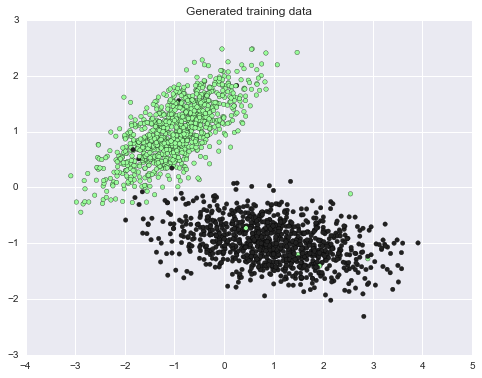

In [2]:
X, y = make_classification(n_samples = 2000, n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1, random_state=123)

plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, cmap=pal)
plt.title("Generated training data")

## Building our classifier

In this simple example we have two features to use in order to build our linear classifier. Our simple classifier is just a weighted linear combination of these features:

$$h(x;\theta,b) = \theta_1 x_1 + \theta_2 x_2 + b$$

where $x_i$ are the features (our $x$ and $y$ coordinates), $\theta_i$ is the weight corresponding to that feature, and $b$ is a bias term.

This equation can be rewritten in vector form as :

$$h(x;\theta,b) = \theta^Tx + b$$

There is one issue that needs addressing with this implementation, however - the value of $h$ is not bounded and can span a huge range. In order for the output to be meaningful in this context (i.e. of predicting class labels) we want to constrain it to being in the range 0 - 1.  In order to do this we'll use a [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function). 

$$h(x;\theta,b) = g(\theta^Tx + b)$$

where:

$$g(z) = \frac{1}{1 + exp(-z)}$$

We will define both the sigmoid function and $g(z)$ in our code below, and also plot the distribution for input values between $\pm10$ in order to demonstrate the behaviour of the sigmoid function. As can be seen in the figure, the function will output a value between 0 and 1, with negative inputs tending to 0 and positive inputs tending to 1. For an input of 0 we'll get a value of 0.5 from the sigmoid function.

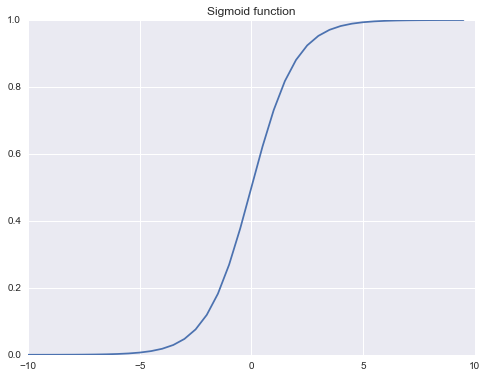

In [3]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def g(X,w,b):
    return 1 / (1 + np.exp(np.dot(X[:,],-w) - b))
    
x = np.arange(-10., 10., 0.5)
plt.plot(x,sigmoid(x))
plt.title("Sigmoid function")

## Training our model on data

Okay, now that we have defined our model we can begin to think about training it on the simulated data. Ideally we would want it to learn is the correct class label for each of the points in the first plot, given their input values for $\theta_1$ ($x$) and $\theta_2$ ($y$).

Specifically:

$$h(x^{(1)};\theta,b) \approx y^{(1)}$$
$$h(x^{(2)};\theta,b) \approx y^{(2)}$$
$$\dots$$
$$h(x^{(N)};\theta,b) \approx y^{(N)}$$

where $x^{(i)}$ corresponds to the $i$th entry in the data, and $y^{(i)}$ is the corresponding class label (0 or 1).

So - how do we go about achieving this?

We need to define a function that will give us some measure of the current *cost* - this is simply the sum of the differences between prediction from our classifier (given by $h$) and the true class labels:

$$J(\theta,b) = \sum_{i=1}^{N} (h(x^{(i)};\theta,b) - y^{(i)})^2 $$

Training our classifier then consists of minimizing this cost function; this will result in getting more of our predictions correct.

In order to minimize this function we'll employ a technique known as [*stochastic gradient descent*](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). This consists of iterating through each of our data points and then updating the values of our weights and bias term ($\theta$ and $b$, respectively) in order to converge on optimal values.  In order to do this we employ the chain rule to calculate the required derivative (we'll need to calculate the partial derivative of the cost function with respect to each of the parameters).

I won't go through the full derivation, which is handled elsewhere (NOTE: provide reference), but the results for our input paramters are:

$$\Delta\theta_1 = 2\left(g(\theta^Tx^{(i)}+b) - y^{(i)}\right)\left(1 - g(\theta^Tx^{(i)}+b)\right)g(\theta^Tx^{(i)}+b)x_{1}^{(i)}$$
$$\Delta\theta_2 = 2\left(g(\theta^Tx^{(i)}+b) - y^{(i)}\right)\left(1 - g(\theta^Tx^{(i)}+b)\right)g(\theta^Tx^{(i)}+b)x_{2}^{(i)}$$
$$\Delta b = 2\left(g(\theta^Tx^{(i)}+b) - y^{(i)}\right)\left(1 - g(\theta^Tx^{(i)}+b)\right)g(\theta^Tx^{(i)}+b)$$

With these equations we can iterate through our data points and update the weights and bias term based on the gradient calculated at each step. The updated terms look like:

$$\theta_1 = \theta_1 - \alpha\Delta\theta_1$$
$$\theta_2 = \theta_2 - \alpha\Delta\theta_2$$
$$b = b - \alpha\Delta b$$

Where $\alpha$ is the _learning rate_, a small positive value that will govern the size of the update that is made to each parameter per iteration.

In practice, we could consider convergence to be when the parameters fall below some threshold but in this case we'll simply iterate a fixed number of times.

To begin with we initialize the weights and bias term randomly:

In [4]:
np.random.seed(1)

# initialize weights randomly with mean of 0
weights = 2*np.random.random((2,1)) - 1
bias = 2*np.random.random(1) - 1
print ("theta_0:", weights[0])
print ("theta_1:", weights[1])
print ("bias:", bias)

theta_0: [-0.16595599]
theta_1: [ 0.44064899]
bias: [-0.99977125]


Now that we have these in place we can begin the process of running stochastic gradient descent.  The code below will pull in a random data point 10000 times, calculate the partial derivatives and then update the parameters accordingly. Several of the 'chunks' used to calculate the partial derivatives are reused so I break this equation up into several steps.

In [5]:
learning_rate = 0.001

for i in range(1000000):

    # pull in a random event from the dataset
    r = randint(0,len(X)-1)

    # now implement stochastic gradient descent to modify weights and bias
    
    # break apart the partial derivative calculations into -slightly- more readable chunks
    chunk_1 =  (2*(g(X[r],weights,bias).T - y[r] ) ).T
    chunk_2 =  (1 - g(X[r],weights,bias))
    chunk_x =  (g(X[r],weights,bias) * X[r,0])   
    chunk_y =  (g(X[r],weights,bias) * X[r,1])
    chunk_b =  (g(X[r],weights,bias))

    # derivative calculations
    delta_w1 = chunk_1*chunk_2 *chunk_x
    delta_w2 = chunk_1*chunk_2 *chunk_y
    delta_b = chunk_1*chunk_2 *chunk_b
    
    # update terms:
    weights[0] -= learning_rate*delta_w1 
    weights[1] -= learning_rate*delta_w2
    bias -= learning_rate*delta_b
    
print ("New parameter values after running SGD:")
print ("theta_0:", weights[0])
print ("theta_1:", weights[1])
print ("bias:", bias)    

New parameter values after running SGD:
theta_0: [-1.54262073]
theta_1: [ 4.20132541]
bias: [-1.00183957]


Great - we have updated parameters. In order to better understand what the linear classifier is doing it is definitely useful to visualise things.  For this I'm making use of a function originally from [this excellent blog post at WildML](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/).

We'll define the function and then plot our decision boundary.

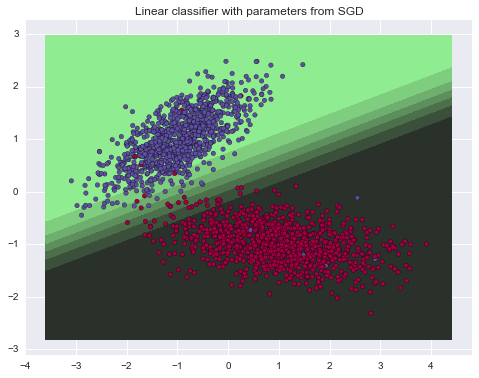

In [6]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=pal)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    
# Plot the decision boundary
plot_decision_boundary(lambda x: sigmoid(np.dot(x,weights) + bias))
plt.title("Linear classifier with parameters from SGD")

As you can see, the classifier has done a good job of separating the two regions. The brightest and darkest greens in the figure correspond to outputs of 0 or 1 - this is where the classifier is most confident in the class label. The gradient that we can see in the region of the boundary corresponds to values between 0 and 1, where the classifier is less certain about the class of the data point.

This certainly seems like a 'sensible' boundary. As a cross check we can also use a logistic regression model from the scikit-learn package - if we fit it to our data and plot it in the same style you can see that it builds a similar boundary:

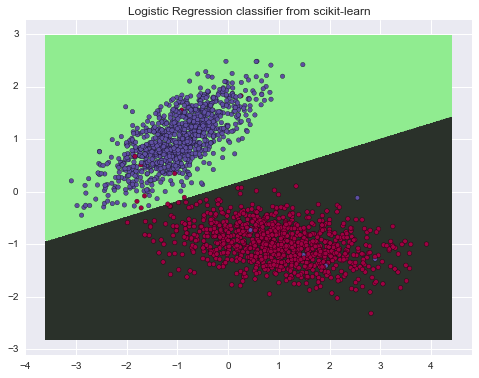

In [7]:
from sklearn import linear_model
clf = linear_model.LogisticRegression()
clf.fit(X, y)

# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression classifier from scikit-learn")

## Problems and next steps

Great - so our simple linear classifier with parameters optimised via stochastic gradient descent has managed to separate our simulated data. This data _was_ linearly separable though, often that isn't the case.  What would happen if instead we attempt this on data with a more complex structure?

We'll use the make_moons function from scikit-learn and repeat the above procedure:

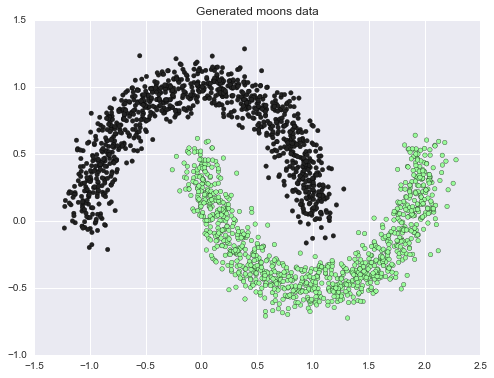

In [8]:
X, y = make_moons(n_samples = 2000, noise = 0.1)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, cmap=pal)
plt.title("Generated moons data")

Reset the parameter values:

In [9]:
# initialize weights randomly with mean of 0
weights = 2*np.random.random((2,1)) - 1
bias = 2*np.random.random(1) - 1
print ("theta_0:", weights[0])
print ("theta_1:", weights[1])
print ("bias:", bias)

theta_0: [ 0.07773389]
theta_1: [ 0.73112819]
bias: [ 0.13791366]


Rerun the SGD algorithm:

In [10]:
learning_rate = 0.001

for i in range(1000000):

    # pull in a random event from the dataset
    r = randint(0,len(X)-1)

    # now implement stochastic gradient descent to modify weights and bias
    
    # break apart the partial derivative calculations into -slightly- more readable chunks
    chunk_1 =  (2*(g(X[r],weights,bias).T - y[r] ) ).T
    chunk_2 =  (1 - g(X[r],weights,bias))
    chunk_x =  (g(X[r],weights,bias) * X[r,0])   
    chunk_y =  (g(X[r],weights,bias) * X[r,1])
    chunk_b =  (g(X[r],weights,bias))

    # derivative calculations
    delta_w1 = chunk_1*chunk_2 *chunk_x
    delta_w2 = chunk_1*chunk_2 *chunk_y
    delta_b = chunk_1*chunk_2 *chunk_b
    
    # update terms
    weights[0] -= learning_rate*delta_w1 
    weights[1] -= learning_rate*delta_w2
    bias -= learning_rate*delta_b
    
print ("New parameter values after running SGD:")
print ("theta_0:", weights[0])
print ("theta_1:", weights[1])
print ("bias:", bias)    

New parameter values after running SGD:
theta_0: [ 0.99926709]
theta_1: [-4.68207653]
bias: [ 0.65725602]


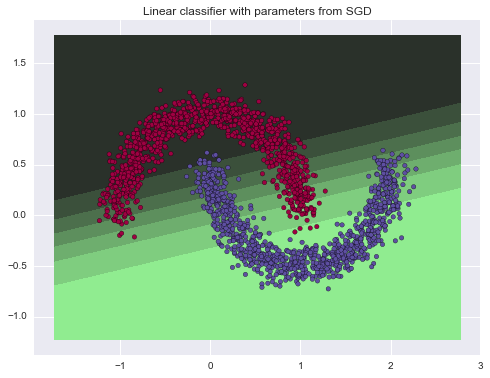

In [11]:
# Plot the decision boundary
plot_decision_boundary(lambda x: sigmoid(np.dot(x,weights) + bias))
plt.title("Linear classifier with parameters from SGD")

Clearly - this was doomed to failure. By construction this linear classifier that we have built can only separate the classes via a straight-line decision boundary and one does not exist that'll separate the moons data we have here.

In part 2 of this series we'll take a look at instead building a non-linear classifier to separate these classes.